In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time

import collections, numpy

import data_loader as dl
import data_transformer as dt

# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths=None):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

In [2]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [3]:
file_name = 'training_50'
data_lim = 2000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 2000/2000 [00:00<00:00, 68406.95it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(2000, (70, 20), 2000, (70, 21), 2000, (70, 3), 2000, (70,))

Load validation data

In [4]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 70371.07it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [5]:
max_len = 500
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v

padded
(1892,) (70, 20)
padded
(1892,) (70, 21)
padded
(1892,) (70, 3)
padded
(1892,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


In [150]:
from sklearn.cluster import KMeans
from keras.utils import to_categorical

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, max_iter=1000).fit(y_train[:500].reshape(-1,3))

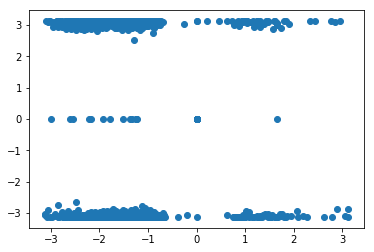

In [154]:
plt.scatter(y_valid[:10][:,:,0], y_valid[:10][:,:,2])

In [247]:
# clusters = np.array([[-1.5, 0, -np.pi], [-1.5, 0, np.pi], [-1.5, 2.5, -np.pi], [-1.5, 2.5, np.pi]])
clusters = np.array([[-1.5, 0, 0], [-1.5, 2.5, 0]])
n_clusters = clusters.shape[0]

In [248]:
import scipy
a = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,3), clusters), axis=1).reshape(y_train.shape[0], y_train.shape[1]) + 1
a, np.unique(a)

(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 2, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]), array([1, 2]))

In [249]:
a[np.logical_not(mask_)] = 0
a, np.unique(a)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]]), array([0, 1, 2]))

In [250]:
# y_train_labels_ = kmeans.predict(y_train.reshape(-1,3)).reshape(y_train.shape[0], y_train.shape[1]) + 1
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,3), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1]) + 1
# y_train_labels_[y_train[:,:,0]==0] = n_clusters-1
y_train_labels_[np.logical_not(mask_)] = 0
print(y_train_labels_.reshape(-1,).shape, np.sum(y_train_labels_ != -1))

# y_valid_labels_ = kmeans.predict(y_valid.reshape(-1,3)).reshape(y_valid.shape[0], y_valid.shape[1]) + 1
y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,3), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1]) + 1
# y_valid_labels_[y_valid[:,:,0]==0] = n_clusters-1
y_valid_labels_[np.logical_not(mask_v)] = 0


# ohe = OneHotEncoder(n_values = n_clusters).fit(y_train_labels)
y_train_labels = to_categorical(y_train_labels_)
y_valid_labels = to_categorical(y_valid_labels_)

y_train_labels.shape, y_valid_labels.shape

(946000,) 946000


((1892, 500, 3), (213, 500, 3))

In [251]:
np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

(array([0, 1, 2]), array([0, 1, 2]), 2)

In [281]:
tf.reset_default_graph()

@tf.custom_gradient
def clip_grad_layer(x):
    def grad(dy):
        return tf.clip_by_value(dy, 1e-10, 1e-10)
    return tf.identity(x), grad

clusters_tf = tf.Variable(initial_value=np.insert(clusters, 0, -100., axis=0), dtype=np.float32, trainable=True)
# clusters_tf = tf.clip_by_value(clusters_tf, -np.pi, np.pi)
# clusters_tf = clip_grad_layer(clusters_tf)

X = tf.placeholder(tf.float32, [None, max_len, 41], name="X")
y = tf.placeholder(tf.float32, [None, max_len, n_clusters+1], name='y')
y_angles = tf.placeholder(tf.float32, [None, max_len, 3], name='y_angles')

mask = tf.not_equal(tf.argmax(y, 2), 0)

conv1a = tf.layers.conv1d(X, 32, 5, activation=tf.nn.relu, padding='same')
conv1b = tf.layers.conv1d(conv1a, 32, 5, activation=tf.nn.relu, padding='same')
conv2a = tf.layers.conv1d(conv1b, 64, 5, activation=tf.nn.relu, padding='same')
conv2b = tf.layers.conv1d(conv2a, 64, 5, activation=tf.nn.relu, padding='same')
conv3 = tf.layers.conv1d(tf.concat([conv1b, conv2b], axis=2), 128, 5, activation=tf.nn.relu, padding='same')

# lstm = bidirectional_lstm(X, 1, 32, keep_prob=0.05)

logits = tf.layers.dense(conv3, n_clusters+1, activation='relu')
y_pred = tf.nn.softmax(logits)

y_masked = tf.boolean_mask(y, mask)
logits_masked = tf.boolean_mask(logits, mask)
y_pred_masked = tf.boolean_mask(y_pred, mask)
y_angles_masked = tf.boolean_mask(y_angles, mask)
shape_after_mask = tf.shape(y_masked)
# y_masked = y
# logits_masked = logits
# y_pred_masked = y_pred
rad_pred = tf.divide(tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked), n_clusters+1)

# Difine the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

mae = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])))

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
# optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(mae)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.global_variables_initializer()

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

Number of parameters: 104556


In [ ]:
batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.001
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value = session.run([optimizer, loss], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_angles: y_train[b:b+batch_size],
                                                                      learning_rate: init_learning_rate})
            
        validation_accuracy, mae_, pred_, clusters_ = session.run([accuracy, mae, prediction, clusters_tf], feed_dict={X: x_valid, y: y_valid_labels, y_angles:y_valid})
        print("loss[epoch=%04d] = %f, val_acc = %f" % (epoch, loss_value, validation_accuracy))    
        print("MAE", mae_)
        print(collections.Counter(pred_))
        print(clusters_)
    
    if epoch % 10 == 0:
        init_learning_rate = init_learning_rate / 1.1
    print("Optimization done")

    # Calculate training accuracy
    train_accuracy_value, pred_train, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                      feed_dict={X: x_train, y: y_train_labels,
                                                                                y_angles: y_train})
    print("Train accuracy:", train_accuracy_value)
    print("Shape after mask:", shape_after_mask_)
    
    # Calculate test accuracy
    test_accuracy_value, pred_test, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                    feed_dict={X: x_valid, y: y_valid_labels,
                                                                              y_angles: y_valid})
    print("Test accuracy:", test_accuracy_value)
    print("Shape after mask:", shape_after_mask_)

Epoch: 0
loss[epoch=0000] = 1.108530, val_acc = 0.274752
MAE 11.150974
Counter({2: 25738, 0: 11847, 1: 49})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 1
loss[epoch=0001] = 1.095320, val_acc = 0.386911
MAE 10.857927
Counter({2: 35489, 0: 1911, 1: 234})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 2
loss[epoch=0002] = 1.088584, val_acc = 0.406388
MAE 10.707758
Counter({2: 36869, 1: 505, 0: 260})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 3
loss[epoch=0003] = 1.083686, val_acc = 0.410825
MAE 10.605558
Counter({2: 36419, 1: 1178, 0: 37})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 4
loss[epoch=0004] = 1.076584, val_acc = 0.423261
MAE 10.471713
Counter({2: 33955, 1: 3676, 0: 3})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 5
loss[epoch=0005] = 1.067941, val_acc = 0.452915
MAE 10.307147
Counter({2: 27438, 1: 10196}

loss[epoch=0049] = 0.709629, val_acc = 0.592098
MAE 1.7515975
Counter({1: 37634})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 50
loss[epoch=0050] = 0.708394, val_acc = 0.592098
MAE 1.7551178
Counter({1: 37634})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 51
loss[epoch=0051] = 0.707273, val_acc = 0.592098
MAE 1.7591255
Counter({1: 37634})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 52
loss[epoch=0052] = 0.706254, val_acc = 0.592098
MAE 1.7633616
Counter({1: 37634})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 53
loss[epoch=0053] = 0.705319, val_acc = 0.592098
MAE 1.7676367
Counter({1: 37634})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 54
loss[epoch=0054] = 0.704459, val_acc = 0.592098
MAE 1.771825
Counter({1: 37634})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 55
loss[epoch=

loss[epoch=0098] = 0.685862, val_acc = 0.596269
MAE 1.8343964
Counter({1: 37217, 2: 417})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 99
loss[epoch=0099] = 0.685482, val_acc = 0.596509
MAE 1.8347347
Counter({1: 37192, 2: 442})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 100
loss[epoch=0100] = 0.685107, val_acc = 0.596854
MAE 1.8350581
Counter({1: 37167, 2: 467})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 101
loss[epoch=0101] = 0.684729, val_acc = 0.596987
MAE 1.8353677
Counter({1: 37150, 2: 484})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 102
loss[epoch=0102] = 0.684350, val_acc = 0.597306
MAE 1.8356642
Counter({1: 37126, 2: 508})
[[-100.  -100.  -100. ]
 [  -1.5    0.     0. ]
 [  -1.5    2.5    0. ]]
Epoch: 103
loss[epoch=0103] = 0.683967, val_acc = 0.597545
MAE 1.8359479
Counter({1: 37093, 2: 541})
[[-100.  -100.  -100. ]
 [  -1.5    0.   

2